In [10]:
import numpy as np; import matplotlib.pyplot as plt; import scipy.signal as scs; import scipy.special as ssp
import statistics as stat; from operator import add; from matplotlib import gridspec; import scipy
from collections import OrderedDict; from labellines import labelLines; import random

In [11]:
############################################################
# Always check parameters below
nLat = 600
nTime = 300
nSims = 2000

############################################################
phi0 = 5. # np.pi
nu = 2.*10**(-3)
omega = 0.25 * 50. * 2. * np.sqrt(nu)
delt = np.sqrt(nu / 2.) * (1. + 0.2)
lenLat = 0.5 * 50. / np.sqrt(2. * nu)
rho = 200. * 2. * np.sqrt(nu) / 2.**3
lamb = delt * np.sqrt(2. / nu)
m2eff = 4. * nu * (- 1. + lamb**2); print(m2eff)

############################################################
alpha = 8.
nCols = 4
n_cross = 2
sigma =  0.03/np.sqrt(m2eff); print(sigma)
############################################################
nyq = int(nLat/2+1)
hLat = int(nLat/2)
hhLat = int(hLat/2)
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
outsize = 4*n_cross*nLat/nTime
dtout = dt*outsize
paper_norm = 1./ phi0 / np.sqrt(2*lenLat)

0.0035199999999999997
0.5056498968474316


In [12]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

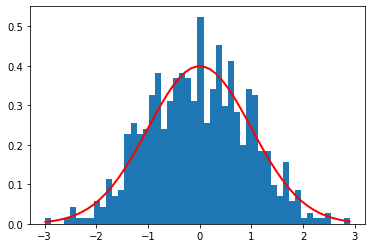

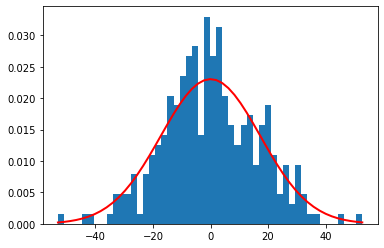

In [13]:
x = np.linspace(0, lenLat, nLat)             # array from 0 to L in N steps
k = np.linspace(0, lenLat, nLat)            # will truncate output to nyq fr

mu = 0.
p_sigma = 1
p_data = np.random.normal(mu, p_sigma, nLat)

plt.figure()
count, bins, ignored = plt.hist(p_data, 50, density=True)
plt.plot(bins, 1/p_sigma/np.sqrt(2*np.pi) * np.exp(-0.5*(bins/p_sigma)**2), linewidth=2, color='r')
plt.show()

f_data = np.fft.rfft(p_data)
f = np.fft.rfftfreq(p_data.size, dx)
f_sigma = p_sigma * np.sqrt(nLat/2.)

plt.figure()
count, bins, ignored = plt.hist(f_data.real, 50, density=True)
plt.plot(bins, 1./f_sigma/np.sqrt(2*np.pi) * np.exp(-0.5*(bins/f_sigma)**2), linewidth=2, color='r')
plt.show()

In [14]:
norm = 1. / phi0 / np.sqrt(2*lenLat)
w2eff = [m2eff + dk**2*(i-1)**2 for i in range(nLat)]       # in simulations
#w2eff = [dk**2*i**2 for i in range(nLat)]                   # scale inv
spec = [norm / w2eff[i]**0.25 for i in range(nLat)]
p_data = np.random.normal(0, 1, len(spec))              # random values drawn from a Gaussian

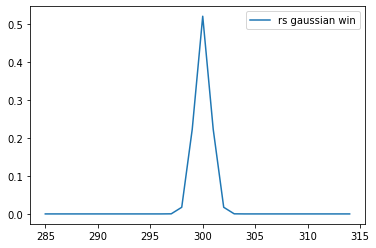

In [15]:
# This whole block creates the filter as ft of rs gaussian
a = [j-1 if j < nLat/2+1 else nLat-j+1 for j in range(1, nLat+1)]
filtera = [np.exp(- 0.5 * ((i-hLat)*dx/sigma)**2) / np.sqrt(2*np.pi) / sigma for i in a]
wind = filtera / sum(filtera)
sp_wind = np.fft.fft(wind, nLat)
sp_wind = [truncate(i.real, 4) for i in sp_wind]

plt.figure()
plt.plot([i for i in range(hLat-15,hLat+15)], wind[hLat-15:hLat+15], label='rs gaussian win')
plt.legend()
plt.show()

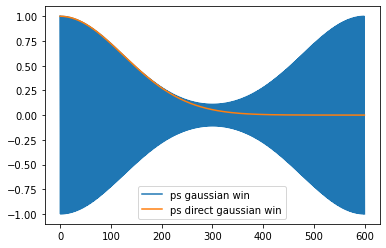

In [16]:
# This is the fiter in k space directly
w = [np.exp(- 0.5 * (dk*k*sigma)**2) for k in range(nLat)]
rs_w = np.fft.ifft(w, nLat)

#print([w1[i]-w2[i] for i in range(nyq)])

plt.figure()
plt.plot(np.arange(len(sp_wind)), sp_wind, label='ps gaussian win')
plt.plot(np.arange(len(w)), w, label='ps direct gaussian win')
plt.legend()
plt.show()

In [17]:
w[nyq]

0.05358641314587327

In [18]:
sp_wind[nyq]

-0.1092

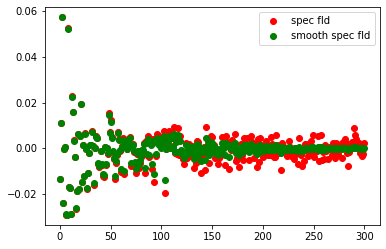

In [19]:
sp_grf = [p_data[i] * spec[i] for i in range(nyq)]             # creates grf with desired spectrum
sm_sp_grf = [w[i] * sp_grf[i] for i in range(nyq)]       # smoothen field

plt.figure()
plt.plot(np.arange(len(sp_grf)), sp_grf, 'ro', label='spec fld')
plt.plot(np.arange(len(sm_sp_grf)), sm_sp_grf, 'go', label='smooth spec fld')
plt.legend()
plt.show()

0.00033134142643999646
0.0003008014898825324


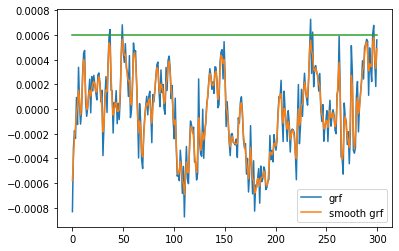

In [20]:
rs_grf = np.fft.irfft(sp_grf, nLat)                   # ft grf to real space
sm_rs_grf = np.fft.irfft(sm_sp_grf, nLat)             # ft smooth grf to real space

mom0 = stat.stdev(rs_grf)
print(mom0)
sm_mom0 = stat.stdev(sm_rs_grf)
print(sm_mom0)

thresh = 2*sm_mom0

plt.figure()
plt.plot(x[0:int(len(x)/2)]/dx, rs_grf[0:int(len(x)/2)], label = 'grf')
plt.plot(x[0:int(len(x)/2)]/dx, sm_rs_grf[0:int(len(sm_rs_grf)/2)], label='smooth grf')
plt.plot(x[0:int(len(x)/2)]/dx, np.ones(int(len(x)/2))*thresh)
plt.legend()
plt.show()

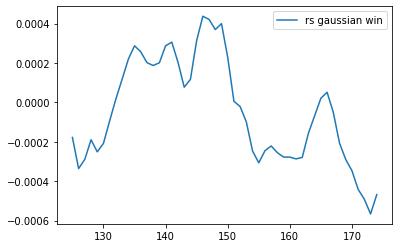

In [21]:
fld = sm_rs_grf[0:int(len(sm_rs_grf)/2)]

plt.figure()
plt.plot([i for i in range(hhLat-25,hhLat+25)], fld[hhLat-25:hhLat+25], label='rs gaussian win')
plt.legend()
plt.show()

0
0
0
(201,)


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


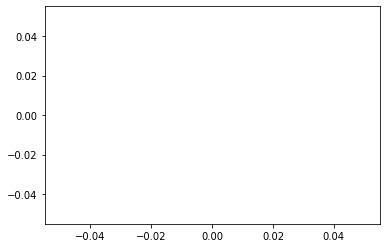

In [22]:
peak_pos, peak_h = scipy.signal.find_peaks(fld, height = thresh) # consider only half iternavl above
x_peak_pos = x[peak_pos]
print(len(x_peak_pos))
rand_pts = lenLat*np.random.rand(len(x_peak_pos))

peak_peak = [p1+p2 for p1 in x_peak_pos for p2 in x_peak_pos if p1 != p2]
peak_peak = [i-nLat if i >= nLat else i for i in peak_peak]
print(len(peak_peak))

peak_rand = [p1+p2 for p1 in x_peak_pos for p2 in rand_pts if p1 != p2]
peak_rand = [i-nLat if i >= nLat else i for i in peak_rand]
print(len(peak_rand))

n_pkpk, binedge = np.histogram(peak_peak, 200) # second arg is #bins
n_pkrand, binedge = np.histogram(peak_rand, 200)
print(np.shape(binedge))

plt.plot(binedge[0:-1],(n_pkpk/n_pkrand) - 1.)

In [23]:
def test(peak_coordinates, random_coordinates, R):
    gal_counter, mixed_counter = 0., 0.
    for peak in peak_coordinates:
        i = peak + R
        if i >= nLat:
            i = i-nLat
        if (i in peak_coordinates):
            gal_counter += 1.
        if (i in random_coordinates):
            mixed_counter += 1.
    return gal_counter, mixed_counter

def correlators(peak_coordinates, R):
    r_correlator, d_correlator = 0., 0.
    N_gal = len(peak_coordinates)
    if N_gal != 0.:
        n_gal = N_gal / nLat
        N_rand = 1000*N_gal   # choose how many random points in sample
        random_coordinates = list(OrderedDict.fromkeys(random.choices(np.arange(nLat), k = N_rand))) 
        N_rand = len(random_coordinates)

        gal, mix = test(peak_coordinates, random_coordinates, R)
        r_correlator += gal / N_gal / n_gal

        if mix != 0.:
            d_correlator += gal * N_rand / mix / N_gal
        else:
            d_correlator += 0.
    else:
        r_correlator += 0.
        d_correlator += 0.
    return r_correlator - 1.,  d_correlator - 1.

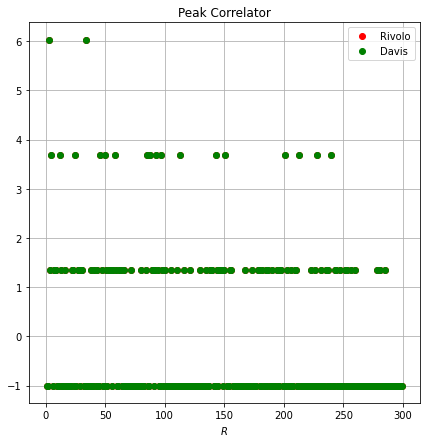

In [24]:
thr = 1*sm_mom0
peak_coordinates, peak_h = scipy.signal.find_peaks(fld, height = thr)

r_correlator, d_correlator = [], []
for R in range(1, hLat):
    r, d = correlators(peak_coordinates, R)
    r_correlator.append(r)
    d_correlator.append(d)

plt.figure(figsize=(7, 7))
plt.title(r'Peak Correlator'); plt.xlabel(r'$R$'); plt.grid()
plt.plot(np.arange(1, hLat), r_correlator, 'ro', label = 'Rivolo')
plt.plot(np.arange(1, hLat), d_correlator, 'go', label = 'Davis')
plt.legend()